In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import math
import pickle
sys.path.append('../')
import torch
from src.config.config import cfg
import matplotlib.pyplot as plt

# from src.modeling.backbone.build import build_backbone, BACKBONE_REGISTRY
# from src.modeling.meta_arch.baseline import build_baseline_model
# from src.modeling.meta_arch.build import build_model
# from src.data.bengali_data import build_data_loader
# from src.modeling.solver.optimizer import build_optimizer
# from src.modeling.solver.evaluation import build_evaluator

In [3]:
from src.tools.find_lr import *

In [4]:
log_lrs, losses = find_lr(cfg)

0 9.582100868225098 0.0677083358168602
100 8.625136375427246 0.1458333432674408
200 9.3049955368042 0.1510416716337204
300 8.838427543640137 0.2447916716337204
400 7.788935661315918 0.1979166716337204
500 7.416871070861816 0.25
600 7.09581995010376 0.3697916865348816
700 6.1077752113342285 0.2083333432674408
800 8.088155746459961 0.4010416865348816
900 7.546280860900879 0.2708333432674408
1000 6.730316162109375 0.1666666716337204
1100 8.204172134399414 0.3385416865348816
1200 10.843878746032715 0.203125


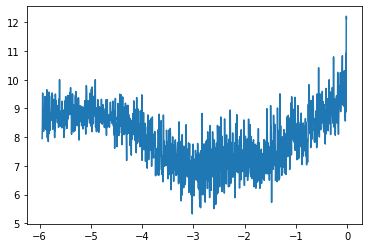

In [5]:
plt.plot(log_lrs,losses)

In [13]:
import math
from functools import partial
from typing import List, Dict, Union, Optional, Iterable

In [14]:
def is_listy(x): return isinstance(x, (list,tuple))

def tensor(x, *rest):
    "Like `torch.as_tensor`, but handle lists too, and can pass multiple vector elements directly."
    if len(rest): x = (x,)+rest
    # XXX: Pytorch bug in dataloader using num_workers>0; TODO: create repro and report
    if is_listy(x) and len(x)==0: return tensor(0)
    res = torch.tensor(x) if is_listy(x) else torch.as_tensor(x)
    if res.dtype is torch.int32:
        #warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
        return res.long()
    return res


def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]


def listify(p=None, q=None):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [17]:
combine_scheds([0.3, 0.7], [sched_cos(0.003, 0.01), sched_cos(0.01, 0.002)]) 

<function __main__.combine_scheds.<locals>._inner(pos)>